Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from os import listdir
from PIL import Image as PImage
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D, BatchNormalization


In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
from glob import glob

In [4]:
!unzip /content/gdrive/MyDrive/CNN_assignment.zip

Archive:  /content/gdrive/MyDrive/CNN_assignment.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024707.jpg  
  inflating

In [5]:
# Delete output of augmentor to start over

![ -e "/content/gdrive/MyDrive/ISIC/Train/actinic keratosis/output" ] && rm -fR "/content/gdrive/MyDrive/ISIC/Train/actinic keratosis/output"
![ -e "/content/gdrive/MyDrive/ISIC/Train/basal cell carcinoma/output" ] && rm -fR "/content/gdrive/MyDrive/ISIC/Train/basal cell carcinoma/output"
![ -e "/content/gdrive/MyDrive/ISIC/Train/dermatofibroma/output" ] && rm -fR "/content/gdrive/MyDrive/ISIC/Train/dermatofibroma/output"
![ -e "/content/gdrive/MyDrive/ISIC/Train/melanoma/output" ] && rm -fR "/content/gdrive/MyDrive/ISIC/Train/melanoma/output"
![ -e "/content/gdrive/MyDrive/ISIC/Train/nevus/output" ] && rm -fR "/content/gdrive/MyDrive/ISIC/Train/nevus/output"
![ -e "/content/gdrive/MyDrive/ISIC/Train/pigmented benign keratosis/output" ] && rm -fR "/content/gdrive/MyDrive/ISIC/Train/pigmented benign keratosis/output"
![ -e "/content/gdrive/MyDrive/ISIC/Train/seborrheic keratosis/output" ] && rm -fR "/content/gdrive/MyDrive/ISIC/Train/seborrheic keratosis/output"
![ -e "/content/gdrive/MyDrive/ISIC/Train/squamous cell carcinoma/output" ] && rm -fR "/content/gdrive/MyDrive/ISIC/Train/squamous cell carcinoma/output"
![ -e "/content/gdrive/MyDrive/ISIC/Train/vascular lesion/output" ] && rm -fR "/content/gdrive/MyDrive/ISIC/Train/vascular lesion/output"

In [6]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [7]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [8]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [9]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds =tf.keras.preprocessing.image_dataset_from_directory(
          directory=data_dir_train,
          class_names=None, color_mode='rgb', batch_size=32, image_size=(180,180),
          shuffle =True, seed=123, validation_split=0.20, subset="training",
          interpolation='bilinear',follow_links=False,smart_resize=False)
        

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [10]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
          directory=data_dir_train,
          class_names=None, color_mode='rgb', batch_size=32, image_size=(180,180),
          shuffle =True, seed=123, validation_split=0.20, subset="validation",
          interpolation='bilinear',follow_links=False,smart_resize=False)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [11]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

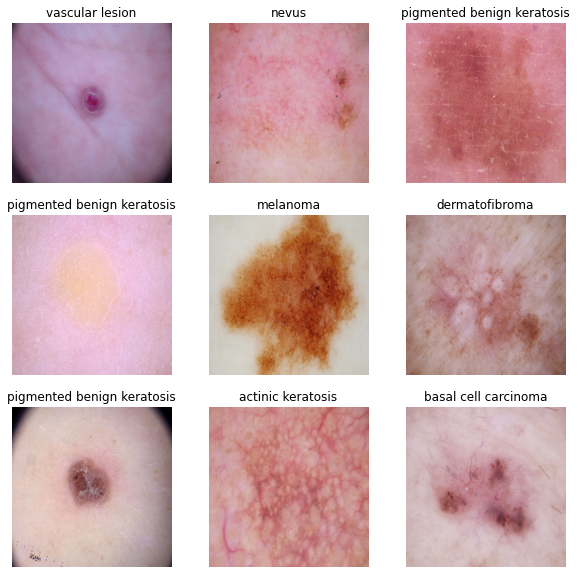

In [12]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [14]:
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [15]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

### Train the model

In [17]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


56/56 [==============================] - 43s 65ms/step - loss: 2.0084 - accuracy: 0.2656 - val_loss: 1.8773 - val_accuracy: 0.3199
Epoch 2/20
56/56 [==============================] - 1s 20ms/step - loss: 1.6973 - accuracy: 0.3934 - val_loss: 1.6985 - val_accuracy: 0.4183
Epoch 3/20
56/56 [==============================] - 1s 20ms/step - loss: 1.4665 - accuracy: 0.4788 - val_loss: 1.3922 - val_accuracy: 0.5280
Epoch 4/20
56/56 [==============================] - 1s 20ms/step - loss: 1.3667 - accuracy: 0.5011 - val_loss: 1.4303 - val_accuracy: 0.5168
Epoch 5/20
56/56 [==============================] - 1s 20ms/step - loss: 1.2852 - accuracy: 0.5530 - val_loss: 1.3324 - val_accuracy: 0.5548
Epoch 6/20
56/56 [==============================] - 1s 20ms/step - loss: 1.1777 - accuracy: 0.5843 - val_loss: 1.4366 - val_accuracy: 0.4989
Epoch 7/20
56/56 [==============================] - 1s 20ms/step - loss: 1.3061 - accuracy: 0.5262 - val_loss: 1.4008 - val_accuracy: 0.5145
Epoch 8/20
56/56 [=====

### Visualizing training results

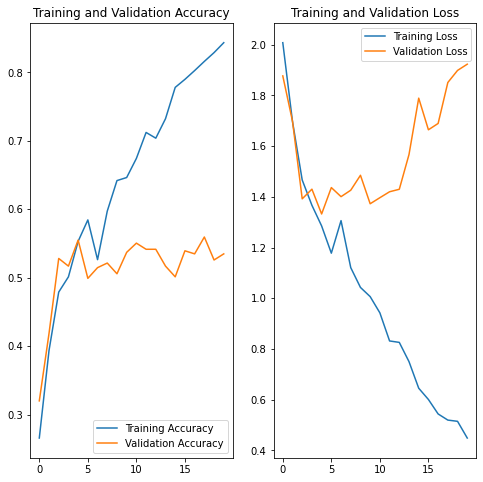

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

- As we can see in above graph training accuracy is close to 85%, where as val accuracy is around 55%.
- This clearly a case of overfitting.
#choose an appropriate data augumentation strategy. 

In [19]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [20]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

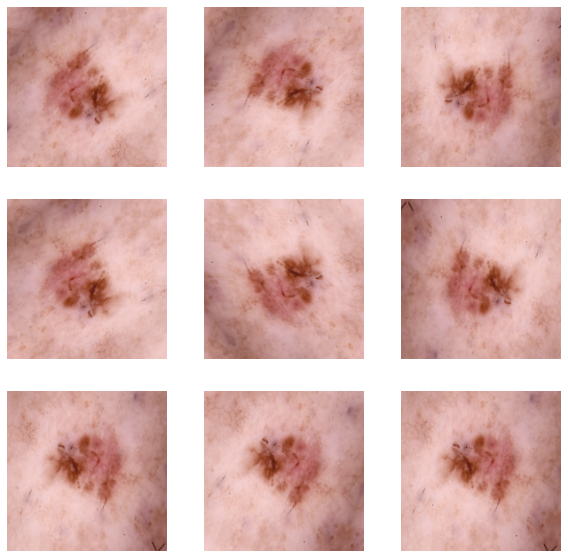

In [21]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [22]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])

### Compiling the model

In [23]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [24]:
## Your code goes here, note: train your model for 20 epochs
## your training code
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


56/56 [==============================] - 2s 26ms/step - loss: 2.2082 - accuracy: 0.1786 - val_loss: 2.0230 - val_accuracy: 0.2282
Epoch 2/20
56/56 [==============================] - 1s 22ms/step - loss: 1.9513 - accuracy: 0.2695 - val_loss: 1.8738 - val_accuracy: 0.3065
Epoch 3/20
56/56 [==============================] - 1s 22ms/step - loss: 1.8284 - accuracy: 0.3315 - val_loss: 1.7364 - val_accuracy: 0.4116
Epoch 4/20
56/56 [==============================] - 1s 22ms/step - loss: 1.6906 - accuracy: 0.3839 - val_loss: 1.6753 - val_accuracy: 0.3624
Epoch 5/20
56/56 [==============================] - 1s 23ms/step - loss: 1.5539 - accuracy: 0.4632 - val_loss: 1.5733 - val_accuracy: 0.4743
Epoch 6/20
56/56 [==============================] - 1s 22ms/step - loss: 1.5335 - accuracy: 0.4414 - val_loss: 1.4855 - val_accuracy: 0.5011
Epoch 7/20
56/56 [==============================] - 1s 22ms/step - loss: 1.4937 - accuracy: 0.4760 - val_loss: 1.5478 - val_accuracy: 0.4787
Epoch 8/20
56/56 [======

### Visualizing the results

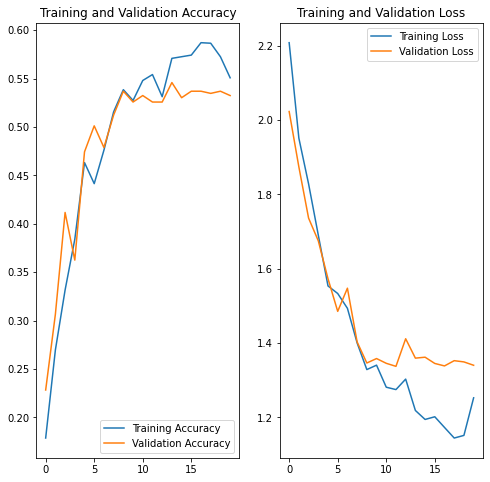

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

- After data augmentation and adding dropout layers, training accuracy is 59% and val accuracy is 51%.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<BarContainer object of 9 artists>

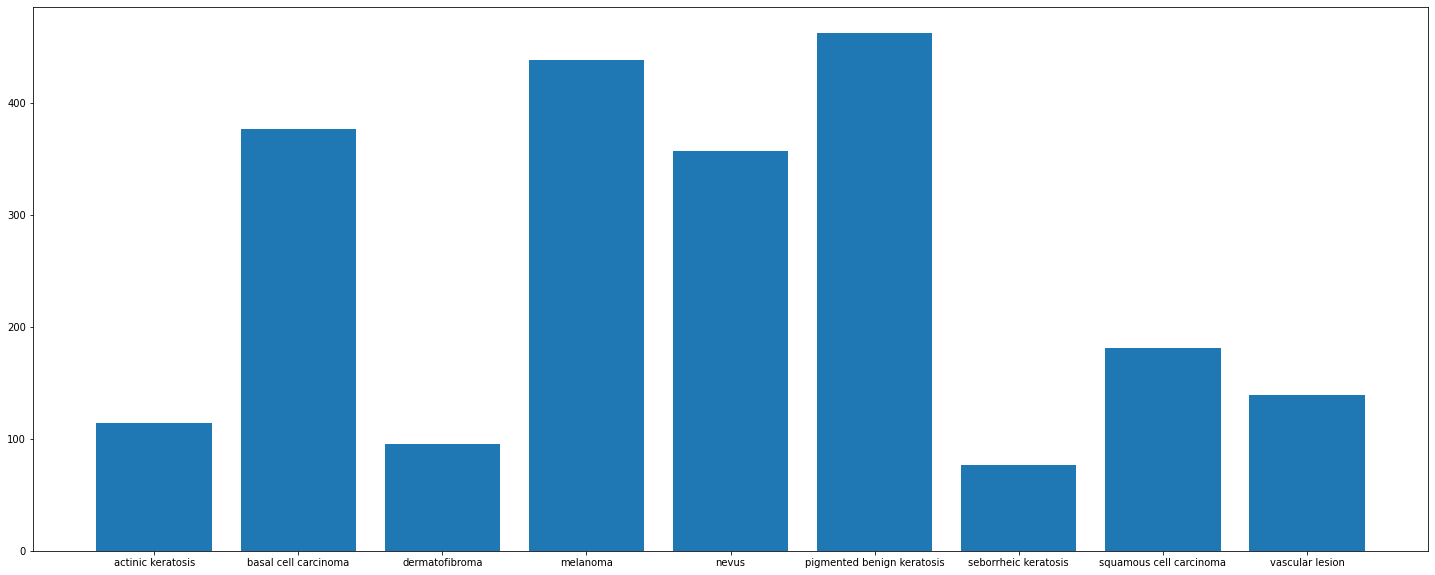

In [26]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
- seborrheic keratosisa

#### - Which classes dominate the data in terms proportionate number of samples?
- pigmented benign keratosis and melanoma


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [27]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [28]:
path_to_training_dataset="Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F895A475C90>: 100%|██████████| 500/500 [00:15<00:00, 31.43 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F895A5483D0>: 100%|██████████| 500/500 [00:16<00:00, 30.91 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F895A7EAED0>:   0%|          | 1/500 [00:00<01:04,  7.71 Samples/s]

Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F895A50E090>: 100%|██████████| 500/500 [00:16<00:00, 30.58 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F895C8ED210>: 100%|██████████| 500/500 [01:17<00:00,  6.47 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3072x2304 at 0x7F895A563F10>: 100%|██████████| 500/500 [01:10<00:00,  7.12 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F895C8B3510>: 100%|██████████| 500/500 [00:15<00:00, 32.92 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F895A452850>:   0%|          | 1/500 [00:00<01:30,  5.53 Samples/s]

Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F89B9AEC590>: 100%|██████████| 500/500 [00:39<00:00, 12.60 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F895A44BAD0>:   1%|          | 3/500 [00:00<01:07,  7.40 Samples/s]

Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F895A5A7A50>: 100%|██████████| 500/500 [00:16<00:00, 30.97 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F895C8EFB50>:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F895A598E90>: 100%|██████████| 500/500 [00:15<00:00, 31.72 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [29]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [30]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010036.jpg_9913f7de-f244-43a2-8eb4-a84fccedf2e0.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010049.jpg_6190fd3c-7403-48f3-8735-a6c1911b86ef.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010350.jpg_6478351b-84e2-4a75-9e65-72ac4e49a7c5.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000310.jpg_408e5cd0-b068-4b09-9180-7360b98b3270.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010235.jpg_28523869-7a4a-44da-8169-65a57b6a16fd.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000463.jpg_10a699f0-aa24-4a07-8213-58c44e73dd38.jpg',
 'Skin cancer IS

In [31]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [32]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [33]:
path_list_old = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]

In [34]:
path_list_old

['Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0010707.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0010551.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0010241.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0010723.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0010049.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0009927.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0010532.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0010765.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0010630.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0010791.jpg',
 'Skin cancer ISIC T

In [35]:
lesion_list_old = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*','*.jpg'))]

In [36]:
lesion_list_old

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [37]:
dataframe_dict_old = dict(zip(path_list_old, lesion_list_old))

In [38]:
original_df = pd.DataFrame(list(dataframe_dict_old.items()),columns = ['Path','Label'])

In [39]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [40]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [41]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [42]:
#data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical')

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [43]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical')

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [44]:
## your code goes here
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [45]:
## your code goes here
model.compile(optimizer='adam',
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [46]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)
# your model fit code

Epoch 1/30
169/169 [==============================] - 26s 147ms/step - loss: 1.9579 - accuracy: 0.2778 - val_loss: 1.4958 - val_accuracy: 0.4068
Epoch 2/30
169/169 [==============================] - 25s 143ms/step - loss: 1.4235 - accuracy: 0.4601 - val_loss: 1.3990 - val_accuracy: 0.4863
Epoch 3/30
169/169 [==============================] - 25s 142ms/step - loss: 1.2234 - accuracy: 0.5410 - val_loss: 1.1616 - val_accuracy: 0.5761
Epoch 4/30
169/169 [==============================] - 25s 143ms/step - loss: 1.0679 - accuracy: 0.6066 - val_loss: 1.0533 - val_accuracy: 0.6088
Epoch 5/30
169/169 [==============================] - 25s 143ms/step - loss: 0.9218 - accuracy: 0.6634 - val_loss: 1.0676 - val_accuracy: 0.6132
Epoch 6/30
169/169 [==============================] - 25s 142ms/step - loss: 0.8158 - accuracy: 0.7057 - val_loss: 0.9047 - val_accuracy: 0.6912
Epoch 7/30
169/169 [==============================] - 25s 143ms/step - loss: 0.6917 - accuracy: 0.7567 - val_loss: 0.9300 - val_ac

#### **Todo:**  Visualize the model results

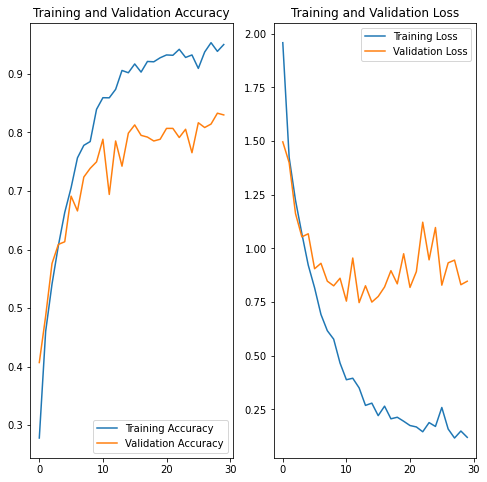

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



#### Yes, class rebalancing helps in mitigating overfitting